In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from kiwipiepy import Kiwi
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager
import collections
from tqdm import tqdm


In [2]:
# con = pymysql.connect(
#     host='localhost',
#     user='root',
#     password='1111',
#     db='yorehalre',
#     charset='utf8'
# )

# data = pd.read_sql("SELECT recipeID, recipe_name, summary, ingredient_name, category, recipe_image_link FROM recipe_info", con)
# data_re = pd.read_sql("SELECT category, recipeID, recipe_name, user_id, rating, review_content FROM user_review", con)

# con.close()

In [7]:
data = pd.read_csv('recipe/weaviate_data.csv')
data_re = pd.read_csv('/Users/choejong-gyu/Documents/GitHub/FASTAPI/recipe/user_review.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'recipe/weaviate_data.csv'

In [ ]:
data

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
1,1,아삭아삭 연근장아찌 만들기,연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...,[재료] 연근 [양념비율(200ml 계량컵 기준)] 간장 1 물 1 설탕 0...,연근은 감자칼로 껍질을 벗겨주었어요. 슥슥 0.5mm정도 잘라주었답니다. 찬물에 식...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
2,2,아보카도 스프레드 연어 샌드위치,근사한 오픈샌드위치 만드는 법을 알려드립니다.,[재료] 식빵 1장 훈제연어 슬라이스 2쪽 오이 1/2개 크랜베리 약간 [양...,오이는 필러로 얇게 슬라이스해 주세요. 식빵은 그릴 팬에서 앞뒤로 바삭하게 구워 주...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
3,3,아보카도 멜론 냉수프 만들기,만들기 간단하고 맛이 고급스러운 멜론 냉수프,[재료] 아보카도 1/4개 멜론 1/4개 우유(농도 조절용으로) 약간,"잘 익은 멜론과 아보카도, 우유를 준비해 주세요. 우유는 농도 조절용으로 사용하셔도...",저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
4,4,훈제연어샐러드 만드는법,연어는 어떻게 먹어도 좋지요~ 다양한 요리 방법 중 이번엔 샐러드로 만들어 보았어요...,[재료] 훈제연어 180g 양상추 치커리 양파 방울토마토 블랙올리브 크루...,연어는 진공포장 그대로 찬물에 담갔다 해동한 후 비닐을 벗겨주세요. 채소는 찬물에 ...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...
...,...,...,...,...,...,...,...
869,869,절대 후회없는 깻잎김치 황금레시피^^,입맛 없을때 깻잎향이 입안가득채워져서 자꾸만 손이가는 깻잎김치예요.\n아주 간단하고...,[재료] 깻잎 30장 [양념] 간장 7T 고춧가루 1T 다진 마늘 0.5T ...,양념장을 먼저 준비해주세요.당근과 대파는 얇고 작게 채썰어주세요.양념장 재료들을 모...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...
870,870,바라깻잎으로 만든~ 깻잎나물- 딸에게# / 깻잎나물 부드럽게 하는 방법 /여름 건강식,NaN,[재료] 깻잎순 300g 홍고추 1/2개 다진파 1T 다진마늘 1/2T 집간...,NaN,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...
871,871,참치깻잎밥전&참치깻잎치즈밥전,비오는날은 전이 생각나잖아요 오늘은 향긋한 깻잎과 참치와 밥을 섞어 다른반찬 필요없...,[재료] 밥 1공기 네모참치 1캔 빨강파프리카 1개 깻잎 20장 달걀 2개 ...,"네모참치,깻잎,파프리카 준비해주시고 깻잎,파프리카 잘게 썰어주세요. 참치캔은 기름기...",치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...
872,872,새우카레덮밥,간단하게 먹을수있는 요리가 없을까 고민하다가 냉동고를 열어보니 새우가 있어서 만들어봤어요,[재료] 칵테일 새우 15마리 양파 1/2개 밥 2공기 [양념] 카레가루 3...,재료와 양념장을 준비해주시고 양파는 채썰어주세요 후라이팬에 올리브유 1T를 넣고 마...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...


In [4]:
data = pd.read_csv('weaviate_data(임시).csv')
data_re = pd.read_csv('user_review.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'weaviate_data(임시).csv'

In [5]:
data_re.head()

NameError: name 'data_re' is not defined

In [6]:
source = []
for ingredient_name in data['ingredient_name']:
    ingredient_name_str = str(ingredient_name)
    if '양념' in ingredient_name_str:
        ingredient_matches = re.findall(r'\[.*?\](.*?)\양념', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    else:
        ingredient_matches = re.findall(r'\[.*?\](.*)', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    # if source_per_ingredient:
    source.append(source_per_ingredient)

NameError: name 'data' is not defined

In [ ]:
data['main_source'] = source

In [ ]:
data_all = pd.DataFrame(columns=['recipe_name', 'all'])
data_all['recipe_name'] = data['recipe_name']
# data_re의 각 행을 반복하면서 조건을 확인하고 데이터 추가
for index, row in data_re.iterrows():
    for i in data['recipe_name']:
        if row.recipe_name == i:
            data_all = pd.concat([data_all, pd.DataFrame({'recipe_name': [row['recipe_name']], 'all': [row['review_content']]})], ignore_index=True)


In [ ]:
data_all = data_all.groupby('recipe_name')['all'].apply(list).reset_index()

In [ ]:
data_all.loc[data_all['recipe_name'] == '우엉양배추볶음밥']

,recipe_name,all
605,우엉양배추볶음밥,[nan]


In [ ]:
df = pd.merge(data, data_all, on=['recipe_name'], how='outer')

In [61]:
df

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link,main_source,all
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[찬, 밥, 적당량, 양배추, 적당량, 우엉, 적당량, 느타리버섯, 조금, 다시마,...","[우엉, 양배추, 볶음밥, 찬밥, 우엉, 양배추, 볶음밥, 찬, 밥, 적당량, 양배..."
1,1,아삭아삭 연근장아찌 만들기,연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...,[재료] 연근 [양념비율(200ml 계량컵 기준)] 간장 1 물 1 설탕 0...,연근은 감자칼로 껍질을 벗겨주었어요. 슥슥 0.5mm정도 잘라주었답니다. 찬물에 식...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,[연근],"[연근, 장아찌, 연근, 비타민, 식이, 섬유소, 빈혈, 예방, 코피, 아이, 혈압..."
2,2,아보카도 스프레드 연어 샌드위치,근사한 오픈샌드위치 만드는 법을 알려드립니다.,[재료] 식빵 1장 훈제연어 슬라이스 2쪽 오이 1/2개 크랜베리 약간 [양...,오이는 필러로 얇게 슬라이스해 주세요. 식빵은 그릴 팬에서 앞뒤로 바삭하게 구워 주...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[식빵, 훈제연어, 슬라이스, 오이, 크랜베리, 약간]","[아보카도, 스프레드, 연어, 샌드위치, 오픈, 샌드위치, 법, 식빵, 훈제연어, ..."
3,3,아보카도 멜론 냉수프 만들기,만들기 간단하고 맛이 고급스러운 멜론 냉수프,[재료] 아보카도 1/4개 멜론 1/4개 우유(농도 조절용으로) 약간,"잘 익은 멜론과 아보카도, 우유를 준비해 주세요. 우유는 농도 조절용으로 사용하셔도...",저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[아보카도, 멜론, 우유농도, 조절용으로, 약간]","[아보카도, 멜론, 냉수프, 맛, 고급, 멜론, 냉수프, 아보카도, 멜론, 우유농도..."
4,4,훈제연어샐러드 만드는법,연어는 어떻게 먹어도 좋지요~ 다양한 요리 방법 중 이번엔 샐러드로 만들어 보았어요...,[재료] 훈제연어 180g 양상추 치커리 양파 방울토마토 블랙올리브 크루...,연어는 진공포장 그대로 찬물에 담갔다 해동한 후 비닐을 벗겨주세요. 채소는 찬물에 ...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[훈제연어, 양상추, 치커리, 양파, 방울토마토, 블랙올리브, 크루통]","[훈제, 연어, 샐러드, 법, 연어, 방법, 중, 이번, 샐러드, 연어, 야채, 맛..."
...,...,...,...,...,...,...,...,...,...
869,866,현미 잣죽,영양가득한 부드러운 잣죽입니다.,[재료] 불린 현미 1/2컵 (또는 백미) 잣 50g 물 5~6컵 [양념] 소금,불린 현미와 물 한컵을 넣고 갈아주고 잣은 잠깐 물에 담궜다가 물 한컵을 넣고 갈아...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[불린, 현미, 또는, 백미, 잣, 물]","[현미, 잣죽, 영양, 잣죽, 불린, 현미, 또는, 백미, 잣, 물, 치매예방, 치..."
870,868,간단한 밑반찬 깻잎찜,착한가격 깻잎으로 만드는 간단한 밑반찬 깻잎찜입니다.,[재료] 깻잎 100장 [양념] 고춧가루 4큰술 간장 4큰술 설탕 1큰술 다...,깻잎은 꼼꼼히 2번 씻어 물기를 빼줍니다. 양념장을 만들어 줍니다. 양념장을 반큰술...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,[깻잎],"[밑반찬, 깻잎, 찜, 가격, 깻잎, 밑반찬, 깻잎, 찜, 깻잎, 감사, 감사, 치..."
871,869,절대 후회없는 깻잎김치 황금레시피^^,입맛 없을때 깻잎향이 입안가득채워져서 자꾸만 손이가는 깻잎김치예요.\n아주 간단하고...,[재료] 깻잎 30장 [양념] 간장 7T 고춧가루 1T 다진 마늘 0.5T ...,양념장을 먼저 준비해주세요.당근과 대파는 얇고 작게 채썰어주세요.양념장 재료들을 모...,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,[깻잎],"[후회, 깻잎, 김치, 황금, 입맛, 깻잎, 향, 입, 안, 손, 깻잎, 김치, 깻..."
872,870,바라깻잎으로 만든~ 깻잎나물- 딸에게# / 깻잎나물 부드럽게 하는 방법 /여름 건강식,NaN,[재료] 깻잎순 300g 홍고추 1/2개 다진파 1T 다진마늘 1/2T 집간...,NaN,치매예방,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[깻잎순, 홍고추, 다진파, 다진마늘, 집간장, 간장, 들기름, 통깨, 물]","[깻잎, 깻잎, 나물, 딸, 깻잎, 나물, 방법, 여름, 건강식, 깻잎순, 홍고추,..."


In [ ]:
kiwi = Kiwi()

def extract_keywords(text):
    stop_words = ['물', '약간', '적당', '적당량', '조금', '때', '레시피', '요리', '저', '거', '것', '수', '나']
    keywords = []
    text = text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    for title in text:
        titles = []
        result = kiwi.analyze(title)
        for token, tag, _ , _ in result[0][0]:
            if tag[0] in 'NN':
                if token not in stop_words and not re.match(r'.*\W.*', token):
                    titles.append(token.strip())
        keywords.append(titles)
    return keywords

In [62]:
name = extract_keywords(df['recipe_name'].apply(str))
summary = extract_keywords(df['summary'].apply(str))
# source = extract_keywords(df['main_source'].apply(str))

In [63]:
review = extract_keywords(df['all'].apply(str))

In [64]:
list_all = []

for item_1, item_2, item_3, item_4, item_5 in zip(name, summary, df['main_source'], review, df['category']):
    combined_list = item_1 + item_2 + item_3 + item_4 + [item_5]
    list_all.append(combined_list)

In [65]:
df['all'] = list_all

In [66]:
all_keyword = []
for i in df['all']:
    for item in i:
        all_keyword.append(item)

unique_keyword = set(all_keyword)

In [ ]:
total_keyword_count = len(set(data['recipe_name']))
keyword_count_dict = dict.fromkeys(unique_keyword)

for keyword_list in df['all']:
    for keyword in keyword_list:
        if keyword_count_dict[keyword.strip()] == None:
            keyword_count_dict[keyword.strip()] = 1
        else:
            keyword_count_dict[keyword.strip()] += 1

In [ ]:
keyword_count_dict
sorted_data_dict = dict(sorted(keyword_count_dict.items(), key=lambda item: item[1], reverse=True))
sorted_data_dict

{'감사': 1368,
 '맛': 934,
 '밥': 374,
 '양파': 357,
 '양념': 333,
 '무': 330,
 '아이': 258,
 '처음': 237,
 '약간': 232,
 '고등어': 215,
 '두부': 214,
 '소금': 213,
 '전': 213,
 '반찬': 211,
 '간': 193,
 '최고': 192,
 '설탕': 190,
 '재료': 187,
 '추가': 185,
 '조림': 185,
 '남편': 184,
 '마늘': 184,
 '간장': 183,
 '건강': 175,
 '번': 175,
 '신랑': 175,
 '소스': 172,
 '덕분': 171,
 '당근': 170,
 '집': 169,
 '성공': 155,
 '무침': 142,
 '미역': 139,
 '가루': 135,
 '샐러드': 132,
 '청양고추': 132,
 '우유': 131,
 '닭': 130,
 '물': 130,
 '국물': 123,
 '입맛': 123,
 '양': 122,
 '정도': 121,
 '감자': 118,
 '법': 117,
 '오이': 116,
 '대파': 115,
 '버섯': 115,
 '가슴살': 114,
 '대신': 113,
 '저녁': 112,
 '양념장': 111,
 '고추': 111,
 '볶음': 111,
 '영양': 110,
 '분': 110,
 '중': 108,
 '향': 107,
 '배': 106,
 '계란': 106,
 '소개': 106,
 '생각': 104,
 '다음': 104,
 '다이어트': 102,
 '부추': 98,
 '오늘': 95,
 '들깨': 95,
 '개': 94,
 '표고버섯': 94,
 '반': 94,
 '듯': 93,
 '그릇': 91,
 '고추장': 91,
 '깻잎': 89,
 '된장': 88,
 '양배추': 88,
 '음식': 87,
 '새우': 86,
 '단호박': 85,
 '스푼': 84,
 '사과': 84,
 '하나': 83,
 '꿀': 81,
 '식감': 81,
 '달걀': 81,
 '김치':

In [ ]:
keyword_representation = pd.DataFrame(0, columns=sorted(unique_keyword), index=df['recipeID'])

In [ ]:
for index, keyword_list in tqdm(enumerate(df['all'])):
    keyword_list = [keyword.strip() for keyword in keyword_list]
    recipeID = df['recipeID'].iloc[index]
    keyword_counts = pd.Series(keyword_list).value_counts()
    keyword_representation.loc[recipeID, keyword_counts.index] += keyword_counts.values

0it [00:00, ?it/s]

874it [00:00, 1389.00it/s]


In [ ]:
keyword_representation

,1숫,2손다,3스픈,n강추,n꾸덕,n낚지,n네모,n마싯게,n맜,n무,...,흰우유,흰자,흰콩,흰후추,흰후추가루,히,히트,힌트,힐링,힘
recipeID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
max_values = keyword_representation.max(axis=1)

In [ ]:
max_values

recipeID
0       4
1       6
2       2
3       3
4       4
       ..
866     2
868     4
869    28
870     4
872     8
Length: 874, dtype: int64

In [ ]:
category_max_list = []
for number, cat in zip(max_values, df['category']):
    total_cat = ','.join([cat] * number * 5)
    category_max_list.append(total_cat)


In [ ]:
list_total = []

for item_1, item_2 in zip(df['all'], category_max_list):
    combined_list = item_1 + [item_2]
    list_total.append(combined_list)

In [ ]:
df['all'] = list_total

In [ ]:
counts_ingr = collections.Counter(all_keyword)

In [ ]:
print (counts_ingr.most_common(20))

[('감사', 1368), ('맛', 934), ('밥', 374), ('양파', 357), ('양념', 333), ('무', 330), ('아이', 258), ('처음', 237), ('약간', 232), ('고등어', 215), ('두부', 214), ('소금', 213), ('전', 213), ('반찬', 211), ('간', 193), ('최고', 192), ('설탕', 190), ('재료', 187), ('조림', 185), ('추가', 185)]


In [ ]:
print (counts_ingr.most_common()[-20:])

[('형제', 1), ('실온', 1), ('쯤', 1), ('대대', 1), ('룸메', 1), ('수정', 1), ('백숙', 1), ('사흘', 1), ('암송', 1), ('광', 1), ('기우', 1), ('바베큐', 1), ('맛있어요힛', 1), ('맛잇엉', 1), ('깻잎순', 1), ('냉동고', 1), ('저의', 1), ('셀러리잎', 1), ('하이라이스', 1), ('초고예요', 1)]


In [ ]:
downsampling = 1e-1
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=5, workers=4, sample = downsampling, sg=1)
word2vec_model.build_vocab(df['all'])
#모든 단어 벡터에 대해 1로 설정하고 Word2Vec 모델에서 단어 벡터를 수정할 수 있다
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.train(df['all'], total_examples = word2vec_model.corpus_count, epochs = 15)
word2vec_vocab = word2vec_model.wv.key_to_index

In [ ]:
print(word2vec_vocab)

{'감사': 0, '맛': 1, '밥': 2, '양파': 3, '양념': 4, '무': 5, '아이': 6, '처음': 7, '약간': 8, '고등어': 9, '두부': 10, '전': 11, '소금': 12, '반찬': 13, '간': 14, '최고': 15, '설탕': 16, '재료': 17, '조림': 18, '추가': 19, '남편': 20, '마늘': 21, '간장': 22, '신랑': 23, '번': 24, '건강': 25, '소스': 26, '덕분': 27, '당근': 28, '집': 29, '성공': 30, '무침': 31, '미역': 32, '가루': 33, '청양고추': 34, '샐러드': 35, '우유': 36, '물': 37, '닭': 38, '입맛': 39, '국물': 40, '양': 41, '정도': 42, '감자': 43, '법': 44, '오이': 45, '버섯': 46, '대파': 47, '가슴살': 48, '대신': 49, '저녁': 50, '볶음': 51, '양념장': 52, '고추': 53, '분': 54, '영양': 55, '중': 56, '향': 57, '배': 58, '소개': 59, '계란': 60, '생각': 61, '다음': 62, '다이어트': 63, '부추': 64, '오늘': 65, '들깨': 66, '개': 67, '반': 68, '표고버섯': 69, '듯': 70, '고추장': 71, '그릇': 72, '깻잎': 73, '된장': 74, '양배추': 75, '음식': 76, '새우': 77, '단호박': 78, '스푼': 79, '사과': 80, '하나': 81, '식감': 82, '꿀': 83, '달걀': 84, '김치': 85, '굿': 86, '가족': 87, '가지': 88, '쌀': 89, '변비': 90, '끼': 91, '간식': 92, '사진': 93, '파프리카': 94, '대추': 95, '생강': 96, '야채': 97, '아침': 98, '매운탕': 99, '실패': 100, '칭찬'

In [ ]:
word2vec_model.wv.vectors.shape

(1195, 300)

In [ ]:
similar_words = {search_term: [item[0] for item in word2vec_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['연근']}
similar_words

{'연근': ['연근전', '본연', '연근조림', '킬러', '주먹밥']}

In [ ]:
print(word2vec_model.wv.most_similar("연근"))

[('연근전', 0.7739822864532471), ('본연', 0.7424543499946594), ('연근조림', 0.7235104441642761), ('킬러', 0.7234949469566345), ('주먹밥', 0.6882968544960022), ('카레', 0.6758217215538025), ('잠', 0.6589133143424988), ('칩', 0.6579210758209229), ('반응', 0.6521596312522888), ('당뇨', 0.6499722003936768)]


In [ ]:
print(word2vec_model.wv["연근"])

[ 7.93521255e-02  3.53557080e-01  2.98450179e-02 -3.00164878e-01
 -2.07366958e-01 -2.36852080e-01  1.50191993e-01  4.37133402e-01
 -1.39789566e-01 -4.52531427e-01  2.97304153e-01 -8.53477642e-02
  9.48034003e-02 -1.46354377e-01  8.24922919e-02 -5.37099019e-02
  1.31616667e-01  3.16282034e-01  5.55115044e-01  1.41787203e-02
 -3.62857282e-01 -6.26819134e-02  4.96987812e-03 -2.40035608e-01
 -2.36879945e-01  3.36071663e-02 -1.71141416e-01 -2.21187815e-01
  1.49402678e-01 -3.69257987e-01  9.09024328e-02  2.75240123e-01
  4.45593834e-01  1.39343396e-01 -2.14606971e-01  2.21419409e-01
 -2.64616549e-01 -7.49137551e-02  7.27816625e-03  1.38347641e-01
 -4.15038923e-03  1.33933514e-01  4.32555914e-01 -9.57817361e-02
 -2.93936014e-01 -3.82161438e-02  1.81882590e-01  2.03971635e-03
  1.84144415e-02  1.75259098e-01  1.07358359e-01 -2.33569086e-01
 -4.53375369e-01  2.33978510e-01 -1.32953182e-01 -2.19548754e-02
 -2.26235986e-02  3.24417651e-02 -3.07708830e-02 -1.89666241e-01
  2.66181320e-01  1.10607

In [ ]:
print(word2vec_model.wv.similarity('무', '고등어'))

0.5271649


In [ ]:
print(word2vec_model.wv.similarity('바나나', '다이어트'))

0.45701364


In [ ]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in list(word2vec_model.wv.index_to_key):
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
document_embedding_list = get_document_vectors(df['all'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 874


In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (874, 874)


In [ ]:
def recommendations(title):
    recipes = df[['recipe_name', 'category', 'recipe_image_link']]

    # 레시피의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['recipe_name']).drop_duplicates()    
    idx = indices[title]

    # 입력된 레시피와 유사한 레시피 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 레시피의 인덱스
    recipe_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = recipes.iloc[recipe_indices].reset_index(drop=True)
    print(recommend[['recipe_name', 'category']])

    fig = plt.figure(figsize=(20, 30))
    font_path = "malgun.ttf"
    font_prop = font_manager.FontProperties(fname=font_path)

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['recipe_image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['recipe_name'])

In [ ]:
recommendations("우엉양배추볶음밥")

KeyError: "['recipe_image_link'] not in index"

In [3]:
data_re.head()

,recipe_name,user_id,posting_time,rating,review_content,category,recipeID,reviewID
0,아삭아삭 연근장아찌 만들기,ronaldo115,2017-06-08 17:52:21,5,연근조림 정말 맛있어요!\n꼭 다이어트해서 설현 몸매가 될거에요 ㅎㅎㅎ,저칼로리 다이어트,1,3341
1,아삭아삭 연근장아찌 만들기,23990030,2018-09-18 23:58:50,5,꿀맛ㅇ,저칼로리 다이어트,1,472
2,아삭아삭 연근장아찌 만들기,66191572,2016-08-24 18:06:15,1,맛있어욤 다름 다이어트 음식도 많이 알려주세요!♡♡♡\n다름이아니라 이 음식을 먹고...,저칼로리 다이어트,1,1953
3,아보카도 스프레드 연어 샌드위치,anna861227,2021-08-20 20:42:15,5,와 이거 진짜 너무 맛있어요 ^^\n독일사는데 간단하게 먹기 딱 좋네용 ㅎㅎ,저칼로리 다이어트,2,3165
4,훈제연어샐러드 만드는법,92394941,2017-06-24 17:08:37,5,정말 맛납니다!!! 감사드려요!,저칼로리 다이어트,4,2869


In [4]:
source = []
for ingredient_name in data['ingredient_name']:
    ingredient_name_str = str(ingredient_name)
    if '양념' in ingredient_name_str:
        ingredient_matches = re.findall(r'\[.*?\](.*?)\양념', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    else:
        ingredient_matches = re.findall(r'\[.*?\](.*)', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    # if source_per_ingredient:
    source.append(source_per_ingredient)

In [5]:
data['main_source'] = source

In [6]:
data_all = pd.DataFrame(columns=['recipe_name', 'all'])
data_all['recipe_name'] = data['recipe_name']
# data_re의 각 행을 반복하면서 조건을 확인하고 데이터 추가
for index, row in data_re.iterrows():
    for i in data['recipe_name']:
        if row.recipe_name == i:
            data_all = pd.concat([data_all, pd.DataFrame({'recipe_name': [row['recipe_name']], 'all': [row['review_content']]})], ignore_index=True)


In [7]:
data_all = data_all.groupby('recipe_name')['all'].apply(list).reset_index()

In [8]:
data_all.loc[data_all['recipe_name'] == '우엉양배추볶음밥']

,recipe_name,all
605,우엉양배추볶음밥,[nan]


In [9]:
df = pd.merge(data, data_all, on=['recipe_name'], how='outer')

In [10]:
df.head()

,recipeID,recipe_name,summary,ingredient_name,full_step,category,image_link,main_source,all
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,찬밥을 준비해주세요. 양배추와 우엉을 준비해주시고 양배추는 깨끗히 씻어서 잘게 잘라...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[찬, 밥, 적당량, 양배추, 적당량, 우엉, 적당량, 느타리버섯, 조금, 다시마,...",[nan]
1,1,아삭아삭 연근장아찌 만들기,연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...,[재료] 연근 [양념비율(200ml 계량컵 기준)] 간장 1 물 1 설탕 0...,연근은 감자칼로 껍질을 벗겨주었어요. 슥슥 0.5mm정도 잘라주었답니다. 찬물에 식...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,[연근],"[nan, 연근조림 정말 맛있어요!\n꼭 다이어트해서 설현 몸매가 될거에요 ㅎㅎㅎ,..."
2,2,아보카도 스프레드 연어 샌드위치,근사한 오픈샌드위치 만드는 법을 알려드립니다.,[재료] 식빵 1장 훈제연어 슬라이스 2쪽 오이 1/2개 크랜베리 약간 [양...,오이는 필러로 얇게 슬라이스해 주세요. 식빵은 그릴 팬에서 앞뒤로 바삭하게 구워 주...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[식빵, 훈제연어, 슬라이스, 오이, 크랜베리, 약간]","[nan, 와 이거 진짜 너무 맛있어요 ^^\n독일사는데 간단하게 먹기 딱 좋네용 ㅎㅎ]"
3,3,아보카도 멜론 냉수프 만들기,만들기 간단하고 맛이 고급스러운 멜론 냉수프,[재료] 아보카도 1/4개 멜론 1/4개 우유(농도 조절용으로) 약간,"잘 익은 멜론과 아보카도, 우유를 준비해 주세요. 우유는 농도 조절용으로 사용하셔도...",저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[아보카도, 멜론, 우유농도, 조절용으로, 약간]",[nan]
4,4,훈제연어샐러드 만드는법,연어는 어떻게 먹어도 좋지요~ 다양한 요리 방법 중 이번엔 샐러드로 만들어 보았어요...,[재료] 훈제연어 180g 양상추 치커리 양파 방울토마토 블랙올리브 크루...,연어는 진공포장 그대로 찬물에 담갔다 해동한 후 비닐을 벗겨주세요. 채소는 찬물에 ...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[훈제연어, 양상추, 치커리, 양파, 방울토마토, 블랙올리브, 크루통]","[nan, 정말 맛납니다!!! 감사드려요!]"


In [11]:
kiwi = Kiwi()

def extract_keywords(text):
    stop_words = ['물', '약간', '적당', '적당량', '조금', '때', '레시피', '요리', '저', '거', '것', '수', '나']
    keywords = []
    text = text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    for title in text:
        titles = []
        result = kiwi.analyze(title)
        for token, tag, _ , _ in result[0][0]:
            if tag[0] in 'NN':
                if token not in stop_words and not re.match(r'.*\W.*', token):
                    titles.append(token.strip())
        keywords.append(titles)
    return keywords

In [12]:
name = extract_keywords(df['recipe_name'].apply(str))
summary = extract_keywords(df['summary'].apply(str))
# source = extract_keywords(df['main_source'].apply(str))

In [13]:
review = extract_keywords(df['all'].apply(str))

In [14]:
list_all = []

for item_1, item_2, item_3, item_4, item_5 in zip(name, summary, df['main_source'], review, df['category']):
    combined_list = item_1 + item_2 + item_3 + item_4 + [item_5]
    list_all.append(combined_list)

In [15]:
df['all'] = list_all

In [16]:
all_keyword = []
for i in df['all']:
    for item in i:
        all_keyword.append(item)

unique_keyword = set(all_keyword)

In [17]:
total_keyword_count = len(set(data['recipe_name']))
keyword_count_dict = dict.fromkeys(unique_keyword)

for keyword_list in df['all']:
    for keyword in keyword_list:
        if keyword_count_dict[keyword.strip()] == None:
            keyword_count_dict[keyword.strip()] = 1
        else:
            keyword_count_dict[keyword.strip()] += 1

In [18]:
keyword_count_dict
sorted_data_dict = dict(sorted(keyword_count_dict.items(), key=lambda item: item[1], reverse=True))
sorted_data_dict

{'감사': 1368,
 '맛': 934,
 '밥': 374,
 '양파': 357,
 '양념': 333,
 '무': 330,
 '아이': 258,
 '처음': 237,
 '약간': 232,
 '고등어': 215,
 '두부': 214,
 '소금': 213,
 '전': 213,
 '반찬': 211,
 '간': 193,
 '최고': 192,
 '설탕': 190,
 '재료': 187,
 '추가': 185,
 '조림': 185,
 '남편': 184,
 '마늘': 184,
 '간장': 183,
 '건강': 175,
 '번': 175,
 '신랑': 175,
 '소스': 172,
 '덕분': 171,
 '당근': 170,
 '집': 169,
 '성공': 155,
 '무침': 142,
 '미역': 139,
 '가루': 135,
 '샐러드': 132,
 '청양고추': 132,
 '우유': 131,
 '닭': 130,
 '물': 130,
 '국물': 123,
 '입맛': 123,
 '양': 122,
 '정도': 121,
 '감자': 118,
 '법': 117,
 '오이': 116,
 '대파': 115,
 '버섯': 115,
 '가슴살': 114,
 '대신': 113,
 '저녁': 112,
 '양념장': 111,
 '고추': 111,
 '볶음': 111,
 '영양': 110,
 '분': 110,
 '중': 108,
 '향': 107,
 '배': 106,
 '계란': 106,
 '소개': 106,
 '생각': 104,
 '다음': 104,
 '다이어트': 102,
 '부추': 98,
 '오늘': 95,
 '들깨': 95,
 '개': 94,
 '표고버섯': 94,
 '반': 94,
 '듯': 93,
 '그릇': 91,
 '고추장': 91,
 '깻잎': 89,
 '된장': 88,
 '양배추': 88,
 '음식': 87,
 '새우': 86,
 '단호박': 85,
 '스푼': 84,
 '사과': 84,
 '하나': 83,
 '꿀': 81,
 '식감': 81,
 '달걀': 81,
 '김치':

In [19]:
keyword_representation = pd.DataFrame(0, columns=sorted(unique_keyword), index=df['recipeID'])

In [20]:
for index, keyword_list in tqdm(enumerate(df['all'])):
    keyword_list = [keyword.strip() for keyword in keyword_list]
    recipeID = df['recipeID'].iloc[index]
    keyword_counts = pd.Series(keyword_list).value_counts()
    keyword_representation.loc[recipeID, keyword_counts.index] += keyword_counts.values

0it [00:00, ?it/s]

874it [00:00, 1389.00it/s]


In [21]:
keyword_representation

,1숫,2손다,3스픈,n강추,n꾸덕,n낚지,n네모,n마싯게,n맜,n무,...,흰우유,흰자,흰콩,흰후추,흰후추가루,히,히트,힌트,힐링,힘
recipeID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
max_values = keyword_representation.max(axis=1)

In [23]:
max_values

recipeID
0       4
1       6
2       2
3       3
4       4
       ..
866     2
868     4
869    28
870     4
872     8
Length: 874, dtype: int64

In [24]:
category_max_list = []
for number, cat in zip(max_values, df['category']):
    total_cat = ','.join([cat] * number * 5)
    category_max_list.append(total_cat)


In [25]:
list_total = []

for item_1, item_2 in zip(df['all'], category_max_list):
    combined_list = item_1 + [item_2]
    list_total.append(combined_list)

In [26]:
df['all'] = list_total

In [27]:
counts_ingr = collections.Counter(all_keyword)

In [28]:
print (counts_ingr.most_common(20))

[('감사', 1368), ('맛', 934), ('밥', 374), ('양파', 357), ('양념', 333), ('무', 330), ('아이', 258), ('처음', 237), ('약간', 232), ('고등어', 215), ('두부', 214), ('소금', 213), ('전', 213), ('반찬', 211), ('간', 193), ('최고', 192), ('설탕', 190), ('재료', 187), ('조림', 185), ('추가', 185)]


In [29]:
print (counts_ingr.most_common()[-20:])

[('형제', 1), ('실온', 1), ('쯤', 1), ('대대', 1), ('룸메', 1), ('수정', 1), ('백숙', 1), ('사흘', 1), ('암송', 1), ('광', 1), ('기우', 1), ('바베큐', 1), ('맛있어요힛', 1), ('맛잇엉', 1), ('깻잎순', 1), ('냉동고', 1), ('저의', 1), ('셀러리잎', 1), ('하이라이스', 1), ('초고예요', 1)]


In [30]:
downsampling = 1e-1
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=5, workers=4, sample = downsampling, sg=1)
word2vec_model.build_vocab(df['all'])
#모든 단어 벡터에 대해 1로 설정하고 Word2Vec 모델에서 단어 벡터를 수정할 수 있다
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.train(df['all'], total_examples = word2vec_model.corpus_count, epochs = 15)
word2vec_vocab = word2vec_model.wv.key_to_index

In [31]:
print(word2vec_vocab)

{'감사': 0, '맛': 1, '밥': 2, '양파': 3, '양념': 4, '무': 5, '아이': 6, '처음': 7, '약간': 8, '고등어': 9, '두부': 10, '전': 11, '소금': 12, '반찬': 13, '간': 14, '최고': 15, '설탕': 16, '재료': 17, '조림': 18, '추가': 19, '남편': 20, '마늘': 21, '간장': 22, '신랑': 23, '번': 24, '건강': 25, '소스': 26, '덕분': 27, '당근': 28, '집': 29, '성공': 30, '무침': 31, '미역': 32, '가루': 33, '청양고추': 34, '샐러드': 35, '우유': 36, '물': 37, '닭': 38, '입맛': 39, '국물': 40, '양': 41, '정도': 42, '감자': 43, '법': 44, '오이': 45, '버섯': 46, '대파': 47, '가슴살': 48, '대신': 49, '저녁': 50, '볶음': 51, '양념장': 52, '고추': 53, '분': 54, '영양': 55, '중': 56, '향': 57, '배': 58, '소개': 59, '계란': 60, '생각': 61, '다음': 62, '다이어트': 63, '부추': 64, '오늘': 65, '들깨': 66, '개': 67, '반': 68, '표고버섯': 69, '듯': 70, '고추장': 71, '그릇': 72, '깻잎': 73, '된장': 74, '양배추': 75, '음식': 76, '새우': 77, '단호박': 78, '스푼': 79, '사과': 80, '하나': 81, '식감': 82, '꿀': 83, '달걀': 84, '김치': 85, '굿': 86, '가족': 87, '가지': 88, '쌀': 89, '변비': 90, '끼': 91, '간식': 92, '사진': 93, '파프리카': 94, '대추': 95, '생강': 96, '야채': 97, '아침': 98, '매운탕': 99, '실패': 100, '칭찬'

In [32]:
word2vec_model.wv.vectors.shape

(1195, 300)

In [33]:
similar_words = {search_term: [item[0] for item in word2vec_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['연근']}
similar_words

{'연근': ['연근전', '본연', '연근조림', '킬러', '주먹밥']}

In [34]:
print(word2vec_model.wv.most_similar("연근"))

[('연근전', 0.7739822864532471), ('본연', 0.7424543499946594), ('연근조림', 0.7235104441642761), ('킬러', 0.7234949469566345), ('주먹밥', 0.6882968544960022), ('카레', 0.6758217215538025), ('잠', 0.6589133143424988), ('칩', 0.6579210758209229), ('반응', 0.6521596312522888), ('당뇨', 0.6499722003936768)]


In [35]:
print(word2vec_model.wv["연근"])

[ 7.93521255e-02  3.53557080e-01  2.98450179e-02 -3.00164878e-01
 -2.07366958e-01 -2.36852080e-01  1.50191993e-01  4.37133402e-01
 -1.39789566e-01 -4.52531427e-01  2.97304153e-01 -8.53477642e-02
  9.48034003e-02 -1.46354377e-01  8.24922919e-02 -5.37099019e-02
  1.31616667e-01  3.16282034e-01  5.55115044e-01  1.41787203e-02
 -3.62857282e-01 -6.26819134e-02  4.96987812e-03 -2.40035608e-01
 -2.36879945e-01  3.36071663e-02 -1.71141416e-01 -2.21187815e-01
  1.49402678e-01 -3.69257987e-01  9.09024328e-02  2.75240123e-01
  4.45593834e-01  1.39343396e-01 -2.14606971e-01  2.21419409e-01
 -2.64616549e-01 -7.49137551e-02  7.27816625e-03  1.38347641e-01
 -4.15038923e-03  1.33933514e-01  4.32555914e-01 -9.57817361e-02
 -2.93936014e-01 -3.82161438e-02  1.81882590e-01  2.03971635e-03
  1.84144415e-02  1.75259098e-01  1.07358359e-01 -2.33569086e-01
 -4.53375369e-01  2.33978510e-01 -1.32953182e-01 -2.19548754e-02
 -2.26235986e-02  3.24417651e-02 -3.07708830e-02 -1.89666241e-01
  2.66181320e-01  1.10607

In [36]:
print(word2vec_model.wv.similarity('무', '고등어'))

0.5271649


In [37]:
print(word2vec_model.wv.similarity('바나나', '다이어트'))

0.45701364


In [38]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in list(word2vec_model.wv.index_to_key):
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [39]:
document_embedding_list = get_document_vectors(df['all'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 874


In [40]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (874, 874)


In [57]:
def recommendations(title):
    recipes = df[['recipe_name', 'summary', 'ingredient_name', 'full_step', 'category', 'image_link', 'main_source', 'all']]

    # 레시피의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['recipe_name']).drop_duplicates()    
    idx = indices[title]

    # 입력된 레시피와 유사한 레시피 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 레시피의 인덱스
    recipe_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = recipes.iloc[recipe_indices].reset_index(drop=True)
    print(recommend[['recipe_name', 'summary', 'ingredient_name', 'full_step', 'category', 'image_link', 'main_source', 'all']])

    fig = plt.figure(figsize=(20, 30))
    font_path = "malgun.ttf"
    font_prop = font_manager.FontProperties(fname=font_path)

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['recipe_name'])

                   recipe_name  \
0                    양배추 밀푀유나베   
1                    양배추 밀푀유나베   
2             호두를 넣은 강된장과 양배추쌈   
3                   양배추감자전 만들기   
4  양배추쌈밥*쌈밥*양배추*양배추효능*별미밥*한끼식사   

                                             summary  \
0  국물과 함께 따끈하게 먹으면 환절기나 추운 겨울철에도 건강메뉴로 아주 좋은 양배추 ...   
1  국물과 함께 따끈하게 먹으면 환절기나 추운 겨울철에도 건강메뉴로 아주 좋은 양배추 ...   
2  오늘은 강된장에 견과류를 넣어 아이들이 밥 비벼 먹어도 맛있게 만들어 보았습니다. ...   
3  감자의 고소한 맛과 아삭아삭 양배추, 사이사이 씹히는 고기가 일품인 양배추감자전을 ...   
4  칼로리가 낮아 살찔염려도 없고 식이섬유가 풍부해 변비에도 효과가 좋은 양배추로 만든...   

                                     ingredient_name  \
0  [재료] 양배추  1/2개 삼겹살(냉동)  300g 마늘  4알 생강 작은거  1조...   
1  [재료] 양배추  1/2개 삼겹살(냉동)  300g 마늘  4알 생강 작은거  1조...   
2  [재료] 양배추  1/2통 다진 돼지고기  150g (또는 쇠고기) 새송이 버섯  ...   
3  [재료] 돼지고기 (불고기)  150g 양배추  1/4개정도 양파  1개 감자  2...   
4                     [재료] 양배추  밥  [양념] 쌈장  양념장  젓갈    

                                           full_step   category  \
0  먼저 찬물에 다시마를 넣고 15분 정도 끓이고 다시마육수를 만듭니다. 양배추는 하나...  

/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  func(*args, **kwargs)
/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  func(*args, **kwargs)
/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  func(*args, **kwargs)
/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  func(*args, **kwargs)
/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 54336 (\N{HANGUL SYLLABLE POE}) missing from current font.
  func(*args, **kwargs)
/Users/choejong-gyu/anaconda3/lib/python3.11/site-packages/I

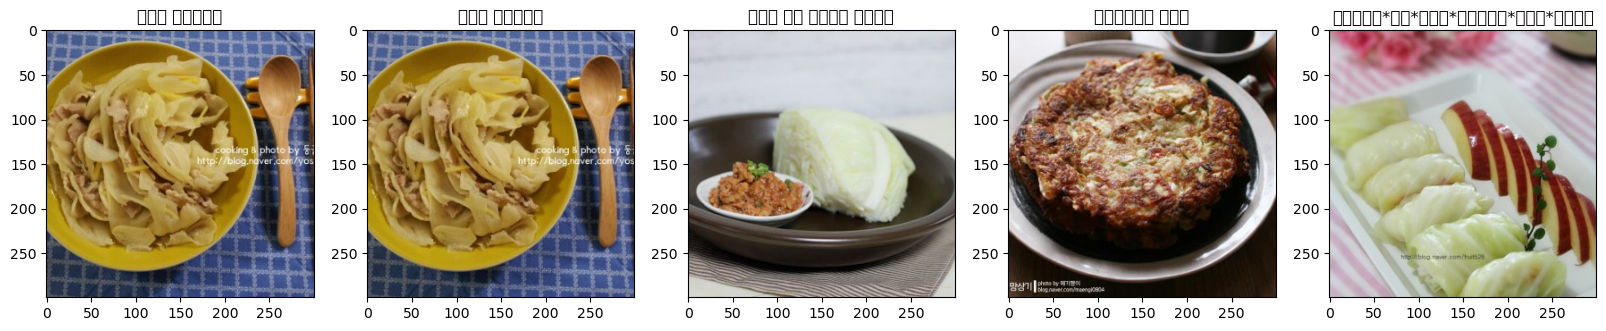

In [58]:
recommendations("우엉양배추볶음밥")

In [60]:
word2vec_model.save("recipe_word2vec_model.bin")

In [46]:
# word2vec_model = Word2Vec.load("recipe_word2vec_model.model")